In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
import optuna
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier, plot_importance
from catboost import CatBoostClassifier

/opt/conda/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:23: UserWarning: You are using pyarrow version 11.0.0 which is known to be insecure. See https://www.cve.org/CVERecord?id=CVE-2023-47248 for further details. Please upgrade to pyarrow>=14.0.1 or install pyarrow-hotfix to patch your current version.
  warnings.warn(


In [2]:
pd.options.display.max_rows=100
pd.options.display.max_columns=None

In [3]:
path = '/kaggle/input/playground-series-s4e3/'
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [4]:
train_data = pd.read_csv(path + 'train.csv')
original_data = pd.read_csv('/kaggle/input/faulty-steel-plates/' + 'faults.csv')
TARGET_FEATURES = ['Pastry', 'Z_Scratch', 'K_Scatch', 'Stains','Dirtiness', 'Bumps', 'Other_Faults']
test_data = pd.read_csv(path + 'test.csv')

In [5]:
train_data.drop(['id'],axis = 1,inplace = True)
test_data.drop(['id'],inplace = True,axis = 1)
train_data = pd.concat([train_data,original_data],axis = 0)
train_data.reset_index(drop=True, inplace=True)

# Drop multi label data points

In [6]:
train_data = train_data[train_data[TARGET_FEATURES].sum(axis=1) <= 1]
train_data['Outside_Global_Index'] = np.where(train_data['Outside_Global_Index']==0.7, 0.5, train_data['Outside_Global_Index'])
targets_bin = train_data[TARGET_FEATURES]
y_xgb = targets_bin

# Create a label encoded target column

In [7]:
train_data['Target'] = np.argmax(train_data[TARGET_FEATURES].values, axis=1) + 1
train_data.loc[train_data[TARGET_FEATURES].sum(axis=1) == 0, 'Target'] = 0

In [8]:
train_data.drop(TARGET_FEATURES, inplace=True,axis =1)

# Feature Engineering

In [9]:
def feature_engineering(data):
    data['Ratio_Length_Thickness'] = data['Length_of_Conveyer'] / data['Steel_Plate_Thickness']
    data['Normalized_Steel_Thickness'] = (data['Steel_Plate_Thickness'] - data['Steel_Plate_Thickness'].min()) / (data['Steel_Plate_Thickness'].max() - data['Steel_Plate_Thickness'].min())
    data['X_Range*Pixels_Areas'] = (data['X_Maximum'] - data['X_Minimum']) * data['Pixels_Areas']
    return data

In [10]:
train_data = feature_engineering(train_data)
test_data = feature_engineering(test_data)

In [11]:
features_to_drop = ['Y_Minimum', 'Steel_Plate_Thickness', 'Sum_of_Luminosity', 'Edges_X_Index', 'SigmoidOfAreas', 'Luminosity_Index', 'TypeOfSteel_A300']

In [12]:
train_data = train_data.drop(features_to_drop,axis = 1)
test_data = test_data.drop(features_to_drop,axis = 1)

In [13]:
X = train_data.drop(['Target'], axis=1)  
y = train_data['Target']  

In [14]:
X

,X_Minimum,X_Maximum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Minimum_of_Luminosity,Maximum_of_Luminosity,Length_of_Conveyer,TypeOfSteel_A400,Edges_Index,Empty_Index,Square_Index,Outside_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Ratio_Length_Thickness,Normalized_Steel_Thickness,X_Range*Pixels_Areas
0,584,590,909977,16,8,5,113,140,1358,1,0.7393,0.4000,0.5000,0.0059,1.0000,0.0,1.2041,0.9031,0.6990,-0.5000,27.1600,0.038462,96
1,808,816,728372,433,20,54,70,111,1687,0,0.7772,0.2878,0.2581,0.0044,1.0000,1.0,2.6365,0.7782,1.7324,0.7419,21.0875,0.153846,3464
2,39,192,2212144,11388,705,420,29,141,1400,1,0.0557,0.5282,0.9895,0.1077,0.3857,0.0,4.0564,2.1790,2.2095,-0.0105,35.0000,0.000000,1742364
3,781,789,3353173,210,16,29,114,134,1387,1,0.7202,0.3333,0.3333,0.0044,0.9310,1.0,2.3222,0.7782,1.4314,0.6667,34.6750,0.000000,1680
4,1540,1560,618502,521,72,67,82,111,1692,1,0.1211,0.5347,0.0842,0.0192,0.9861,1.0,2.7694,1.4150,1.8808,0.9158,5.6400,1.000000,10420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21155,249,277,325796,273,54,22,119,141,1360,1,0.3662,0.3906,0.5714,0.0206,0.7273,0.0,2.4362,1.4472,1.2041,-0.4286,34.0000,0.000000,7644
21156,144,175,340598,287,44,24,112,133,1360,1,0.2118,0.4554,0.5484,0.0228,0.7083,0.0,2.4579,1.4914,1.2305,-0.4516,34.0000,0.000000,8897
21157,145,174,386794,292,40,22,120,140,1360,1,0.2132,0.3287,0.5172,0.0213,0.6818,0.0,2.4654,1.4624,1.1761,-0.4828,34.0000,0.000000,8468
21158,137,170,422528,419,97,47,117,140,1360,1,0.2015,0.5904,0.9394,0.0243,0.6596,0.0,2.6222,1.5185,1.4914,-0.0606,34.0000,0.000000,13827


## XGB Training

In [15]:
RETRAIN_XGB_MODEL = False
def objective(trial):
    # Define hyperparameters to tune
    param = {
        'grow_policy': trial.suggest_categorical('grow_policy', ["depthwise", "lossguide"]),
        'multi_strategy': trial.suggest_categorical('multi_strategy', ["one_output_per_tree"]),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'gamma' : trial.suggest_float('gamma', 1e-5, 0.5, log=True),
        'subsample': trial.suggest_float('subsample', 0.3, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0, log=True),
        
    }
    param['n_estimators'] = 3000
    param['early_stopping_rounds'] = 50
    param['booster'] = 'gbtree'
    param["verbosity"] = 0
    param['tree_method'] = "hist"
    
    auc_scores = []

    for train_idx, valid_idx in cv.split(X, y):

        X_train_fold, X_valid_fold = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_fold, y_valid_fold = y.iloc[train_idx], y.iloc[valid_idx]
        y_xgb_train_fold, y_xgb_valid_fold = y_xgb.iloc[train_idx], y_xgb.iloc[valid_idx]
                
        # Create and fit the model
        model = XGBClassifier(**param)
        model.fit(X_train_fold, y_xgb_train_fold, eval_set=[(X_valid_fold, y_xgb_valid_fold)],verbose=False)

        # Predict class probabilities
        y_prob = model.predict_proba(X_valid_fold)

        # Compute the AUC for each class and take the average
        average_auc = roc_auc_score(targets_bin.iloc[valid_idx], y_prob, multi_class="ovr", average="macro")
        auc_scores.append(average_auc)

    # Return the average AUC score across all folds
    return np.mean(auc_scores)


if RETRAIN_XGB_MODEL:
    study = optuna.create_study(direction='maximize',study_name = "xgb_model_training")
    study.optimize(objective, n_trials=200)  # Adjust the number of trials as necessary
    # Output the optimization results
    print(f"Best trial average AUC: {study.best_value:.4f}")
    print(study.best_params)
    for key, value in study.best_params.items():
        print(f"{key}: {value}")

## LGBM Training

In [16]:
RETRAIN_LGBM_MODEL = False
# Define the objective function for Optuna optimization
def objective(trial):
    # Define parameters to be optimized for the LGBMClassifier
    
    param = {
    'objective': 'multiclass',  # Equivalent to multi:softmax but needs num_class as well
    'num_class': 8,  # Specify the number of classes if your task is multi-class classification
    'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
    'n_estimators': 3000,
    'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
    'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    'max_depth': trial.suggest_int('max_depth', 3, 15),
    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
    'subsample': trial.suggest_float('subsample', 0.5, 1.0),
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 8),
    'device_type': 'cpu',
    'num_leaves': trial.suggest_int('num_leaves', 4, 2048),
    "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
    "verbosity": -1,
    "early_stopping_rounds": 50,
    }

    auc_scores = []

    for train_idx, valid_idx in cv.split(X, y):

        X_train_fold, X_valid_fold = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_fold, y_valid_fold = y.iloc[train_idx], y.iloc[valid_idx]

        # Create and fit the model
        model = LGBMClassifier(**param)
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_valid_fold, y_valid_fold)], verbose=False)

        # Predict class probabilities
        y_prob = model.predict_proba(X_valid_fold)

        # Compute the AUC for each class and take the average
        average_auc = roc_auc_score(targets_bin.iloc[valid_idx], y_prob[:, 1:], multi_class="ovr", average="macro")
        auc_scores.append(average_auc)

    # Return the average AUC score across all folds
    return np.mean(auc_scores)

# Run Optuna optimization
if RETRAIN_LGBM_MODEL:
    lgbm_study = optuna.create_study(direction='maximize',study_name = "lgbm_model_training")
    lgbm_study.optimize(objective, n_trials=200)  # Adjust the number of trials as necessary

    # Output the optimization results
    print(f"Best trial average AUC: {study.best_value:.4f}")
    print(study.best_params)
    for key, value in study.best_params.items():
        print(f"{key}: {value}")

## Catboost Training

In [17]:
RETRAIN_CATBOOST_MODEL = False

def objective(trial):
    # Define parameters to be optimized for the CatBoostClassifier
    param = {
        "loss_function": "MultiClass",
        "eval_metric": "MultiClass",
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1),
        'n_estimators': 2000,
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 0.001, 10.0, log=True),
        "depth": trial.suggest_int("depth", 4, 10),
#         "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.99),
        "subsample": trial.suggest_float("subsample", 0.4, 1.0),
        "bootstrap_type": "Bernoulli",
        "early_stopping_rounds": 100,
        "task_type": 'CPU',
        "verbose": False
    }

    auc_scores = []

    for train_idx, valid_idx in cv.split(X, y):
        X_train_fold, X_valid_fold = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_fold, y_valid_fold = y.iloc[train_idx], y.iloc[valid_idx]

        # Create and fit the model
        model = CatBoostClassifier(**param)
        model.fit(X_train_fold, y_train_fold, eval_set=[(X_valid_fold, y_valid_fold)])

        # Predict class probabilities
        y_prob = model.predict_proba(X_valid_fold)

        # Compute the AUC for each class and take the average
        average_auc = roc_auc_score(targets_bin.iloc[valid_idx], y_prob[:, 1:], multi_class="ovr", average="macro")
        auc_scores.append(average_auc)

    # Return the average AUC score across all folds
    return np.mean(auc_scores)

if RETRAIN_CATBOOST_MODEL:
    # Run Optuna optimization
    catboost_study = optuna.create_study(direction='maximize', study_name="catboost_model_training")
    catboost_study.optimize(objective, n_trials=200)  # Adjust the number of trials as necessary

    # Output the optimization results
    print(f"Best trial average AUC: {study.best_value:.4f}")
    print(study.best_params)
    for key, value in study.best_params.items():
        print(f"{key}: {value}")

## HGBC Training

In [18]:
RETRAIN_HGBC_MODEL = False

def objective(trial):
    # Define hyperparameters to tune
    param = {
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'max_iter': trial.suggest_int('max_iter', 100, 2500),  # Equivalent to n_estimators
        'max_depth': trial.suggest_int('max_depth', 3, 20),
        'l2_regularization': trial.suggest_float('l2_regularization', 1e-8, 10.0, log=True),  # Equivalent to reg_lambda
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 20, 300),
        'max_bins': trial.suggest_int('max_bins', 25, 255),
    }
    
    auc_scores = []

    for train_idx, valid_idx in cv.split(X, y):
        X_train_fold, X_valid_fold = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_fold, y_valid_fold = y.iloc[train_idx], y.iloc[valid_idx]

        # Create and fit the model
        model = HistGradientBoostingClassifier(**param)
        model.fit(X_train_fold, y_train_fold)

        # Predict class probabilities
        y_prob = model.predict_proba(X_valid_fold)

        # Compute the AUC for each class and take the average
        average_auc = roc_auc_score(targets_bin.iloc[valid_idx], y_prob[:, 1:], multi_class="ovr", average="macro")
        auc_scores.append(average_auc)

    # Return the average AUC score across all folds
    return np.mean(auc_scores)


if RETRAIN_HGBC_MODEL:
    # Example usage with Optuna
    hgbc_study = optuna.create_study(direction='maximize', study_name="HistGradientBoostingClassifier_model_training")
    hgbc_study.optimize(objective, n_trials=200)  # Adjust the number of trials as necessary

    # Output the optimization results
    print(f"Best trial average AUC: {study.best_value:.4f}")
    print(study.best_params)
    for key, value in study.best_params.items():
        print(f"{key}: {value}")

In [19]:
lgbm_params = {
    "objective": "multiclass",
    'num_class': 8,
    "boosting_type": "gbdt",
    "verbosity": -1,
    "early_stopping_rounds": 50,
    'n_estimators': 3000,
    'learning_rate': 0.00711725041768046,
    'lambda_l1': 0.00440985033109004,
    'lambda_l2': 1.0606279361419868e-08,
    'max_depth': 8,
    'colsample_bytree': 0.33443191322905963,
    'subsample': 0.6551114943335209,
    'min_child_weight': 1,
    'num_leaves': 1019,
    'min_child_samples': 94,
}

cat_params = {
    "loss_function": "MultiClass",
    "eval_metric": "MultiClass",
    "bootstrap_type": "Bernoulli",
    "early_stopping_rounds": 100,
    "verbose": False,
    'n_estimators': 2000,
    'learning_rate': 0.018384945397206656,
    'l2_leaf_reg': 0.8746200477430335,
    'depth': 6,
    'colsample_bylevel': 0.1250483657354198,
    'subsample': 0.8794673581253512
}

xgb_params = {
    'grow_policy': 'depthwise',
    'multi_strategy': 'multi_output_tree',
    'n_estimators': 3000,
    'early_stopping_rounds': 50,
    'learning_rate': 0.011991933688453596,
    'gamma': 0.037522403671044376,
    'subsample': 0.8810951837647127,
    'colsample_bytree': 0.36803100807865063,
    'max_depth': 7,
    'min_child_weight': 2,
    'lambda': 0.38010636016035176,
    'alpha': 0.047233571811149226,
}

hgbc_params = {
    'learning_rate': 0.038914759891422,
    'max_iter': 1381,
    'max_depth': 4,
    'l2_regularization': 9.698385966882728e-07,
    'min_samples_leaf': 281,
    'max_bins': 100
}

In [20]:
def compute_oof(X, y, model, model_name, cv):
    
    cv_oof = pd.DataFrame(np.zeros((len(y), len(TARGET_FEATURES))), columns=TARGET_FEATURES)
    prob_predictions_test = []
    for train_idx, valid_idx in cv.split(X, y):
        X_train_fold, X_valid_fold = X.iloc[train_idx], X.iloc[valid_idx]
        y_train_fold, y_valid_fold = y.iloc[train_idx], y.iloc[valid_idx]
        y_xgb_train_fold, y_xgb_valid_fold = y_xgb.iloc[train_idx], y_xgb.iloc[valid_idx]

        prob_predictions = []
        if model_name == 'XGB':
            model.fit(X_train_fold, y_xgb_train_fold, eval_set=[(X_valid_fold, y_xgb_valid_fold)],verbose=False)
            cv_oof.iloc[valid_idx, :] = model.predict_proba(X_valid_fold)
            prob_predictions_test.append(model.predict_proba(test_data))
        elif model_name == 'LGBM':
            model.fit(X_train_fold, y_train_fold, eval_set=[(X_valid_fold, y_valid_fold)])
            cv_oof.iloc[valid_idx, :] = model.predict_proba(X_valid_fold)[:, 1:]
            prob_predictions_test.append(model.predict_proba(test_data)[:, 1:])
        elif model_name == 'CAT':
            model.fit(X_train_fold, y_train_fold, eval_set=[(X_valid_fold, y_valid_fold)])
            cv_oof.iloc[valid_idx, :] = model.predict_proba(X_valid_fold)[:, 1:]
            prob_predictions_test.append(model.predict_proba(test_data)[:, 1:])
        else:
            model.fit(X_train_fold, y_train_fold)
            cv_oof.iloc[valid_idx, :] = model.predict_proba(X_valid_fold)[:, 1:]
            prob_predictions_test.append(model.predict_proba(test_data)[:, 1:])
    preds = np.mean(prob_predictions_test, axis=0)
    return cv_oof, preds

In [21]:
cat_oof, cat_preds = compute_oof(X, y, CatBoostClassifier(**cat_params), 'CAT', cv)

In [22]:
xgb_oof, xgb_preds = compute_oof(X, y, XGBClassifier(**xgb_params), 'XGB', cv)
lgbm_oof, lgbm_preds = compute_oof(X, y, LGBMClassifier(**lgbm_params), 'LGBM', cv)

In [23]:
hgbc_oof, hgbc_preds = compute_oof(X, y, HistGradientBoostingClassifier(**hgbc_params), 'HGBC', cv)

In [24]:
MinMax = 0
# 0 None
# 1 MinMax min to 0 max to 1
# 2 scale a row sum to 1
if MinMax == 1:
    xgb_oof = MinMaxScaler().fit_transform(xgb_oof)
    lgbm_oof = MinMaxScaler().fit_transform(lgbm_oof)
    cat_oof = MinMaxScaler().fit_transform(cat_oof)
    hgbc_oof = MinMaxScaler().fit_transform(hgbc_oof)
    xgb_preds = MinMaxScaler().fit_transform(xgb_preds)
    lgbm_preds = MinMaxScaler().fit_transform(lgbm_preds)
    cat_preds = MinMaxScaler().fit_transform(cat_preds)
    hgbc_preds = MinMaxScaler().fit_transform(hgbc_preds)
elif MinMax == 2:
    xgb_oof = xgb_oof.div(xgb_oof.sum(axis=1), axis=0)
    lgbm_oof = lgbm_oof.div(lgbm_oof.sum(axis=1), axis=0)
    cat_oof = cat_oof.div(cat_oof.sum(axis=1), axis=0)
    hgbc_oof = hgbc_oof.div(hgbc_oof.sum(axis=1), axis=0)
    xgb_oof = np.array(xgb_oof)
    lgbm_oof = np.array(lgbm_oof)
    cat_oof = np.array(cat_oof)
    hgbc_oof = np.array(hgbc_oof)
    xgb_preds = xgb_preds / xgb_preds.sum(axis=1, keepdims=True)
    lgbm_preds = lgbm_preds / lgbm_preds.sum(axis=1, keepdims=True)
    cat_preds = cat_preds / cat_preds.sum(axis=1, keepdims=True)
    hgbc_preds = hgbc_preds / hgbc_preds.sum(axis=1, keepdims=True)
else:
    xgb_oof = np.array(xgb_oof)
    lgbm_oof = np.array(lgbm_oof)
    cat_oof = np.array(cat_oof)
    hgbc_oof = np.array(hgbc_oof)
    xgb_preds = np.array(xgb_preds)
    lgbm_preds = np.array(lgbm_preds)
    cat_preds = np.array(cat_preds)
    hgbc_preds = np.array(hgbc_preds)

In [25]:
xgb_score = roc_auc_score(targets_bin, xgb_oof, multi_class='ovr')
lgbm_score = roc_auc_score(targets_bin, lgbm_oof, multi_class='ovr')
cat_score = roc_auc_score(targets_bin, cat_oof, multi_class='ovr')
hgbc_score = roc_auc_score(targets_bin, hgbc_oof, multi_class='ovr')

print(f"oof roc-auc score for XGB  model: {xgb_score:0.5f}")
print(f"oof roc-auc score for LGBM model: {lgbm_score:0.5f}")
print(f"oof roc-auc score for CAT  model: {cat_score:0.5f}")
print(f"oof roc-auc score for HGBC model: {hgbc_score:0.5f}")

oof roc-auc score for XGB  model: 0.89893
oof roc-auc score for LGBM model: 0.90011
oof roc-auc score for CAT  model: 0.89944
oof roc-auc score for HGBC model: 0.89678


In [26]:
from functools import partial
from scipy.optimize import minimize

blend = np.zeros((xgb_oof.shape[0], xgb_oof.shape[1]))
preds = np.zeros((xgb_preds.shape[0], xgb_preds.shape[1]))

initial_weights = np.array([0.25, 0.25, 0.25, 0.25])

def calculate_roc_auc(weights, oof_1, oof_2, oof_3, oof_4, target):
    # Normalize weights
    weights /= np.sum(weights)
    
    # Calculate weighted sum
    weighted_sum = oof_1 * weights[0] + oof_2 * weights[1] + oof_3 * weights[2] + oof_4 * weights[3]
    
    # Calculate ROC AUC score
    score = roc_auc_score(target, weighted_sum, multi_class='ovr')
    
    # Return negative score to maximize during optimization
    return -score

# Define bounds for each weight (greater than or equal to 0)
bounds = [(0, None), (0, None), (0, None), (0, None)]

for k in range(len(TARGET_FEATURES)):
    result = minimize(partial(calculate_roc_auc, 
                              oof_1=xgb_oof[:, k],
                              oof_2=lgbm_oof[:, k],
                              oof_3=cat_oof[:, k],
                              oof_4=hgbc_oof[:, k],
                              target=targets_bin.iloc[:, k]), 
                      initial_weights, 
                      method='Nelder-Mead',
                      bounds=bounds)
    
    optimal_weights = result.x / np.sum(result.x)
    
    # Update print statement and calculation for four models
    print(f"Class {TARGET_FEATURES[k]} optimal weights: XGB={optimal_weights[0]:0.3f}, LGBM={optimal_weights[1]:0.3f}, CAT={optimal_weights[2]:0.3f}, HGBC={optimal_weights[3]:0.3f}")
    blend[:, k] = (xgb_oof[:, k] * optimal_weights[0] + lgbm_oof[:, k] * optimal_weights[1] +
                   cat_oof[:, k] * optimal_weights[2] + hgbc_oof[:, k] * optimal_weights[3])
    preds[:, k] = (xgb_preds[:, k] * optimal_weights[0] + lgbm_preds[:, k] * optimal_weights[1] +
                   cat_preds[:, k] * optimal_weights[2] + hgbc_preds[:, k] * optimal_weights[3])

Class Pastry optimal weights: XGB=0.143, LGBM=0.281, CAT=0.576, HGBC=0.000
Class Z_Scratch optimal weights: XGB=0.189, LGBM=0.574, CAT=0.018, HGBC=0.220
Class K_Scatch optimal weights: XGB=0.204, LGBM=0.727, CAT=0.061, HGBC=0.009
Class Stains optimal weights: XGB=0.067, LGBM=0.446, CAT=0.422, HGBC=0.065
Class Dirtiness optimal weights: XGB=0.001, LGBM=0.575, CAT=0.425, HGBC=0.000
Class Bumps optimal weights: XGB=0.135, LGBM=0.433, CAT=0.433, HGBC=0.000
Class Other_Faults optimal weights: XGB=0.352, LGBM=0.413, CAT=0.125, HGBC=0.110


In [27]:
blend_score = roc_auc_score(targets_bin, blend, multi_class='ovr')
print(f"oof roc-auc score for blend of models: {blend_score:0.5f}")

oof roc-auc score for blend of models: 0.90108


In [28]:
submission = pd.read_csv(path + 'sample_submission.csv')
submission.iloc[:, 1:] = preds

In [29]:
submission.to_csv("submission.csv", index=False)

In [30]:
submission

,id,Pastry,Z_Scratch,K_Scatch,Stains,Dirtiness,Bumps,Other_Faults
0,19219,0.535901,0.002343,0.003975,0.000182,0.025832,0.127405,0.326593
1,19220,0.255770,0.015482,0.007964,0.000409,0.159641,0.187071,0.340308
2,19221,0.001935,0.039082,0.048350,0.000766,0.005253,0.299931,0.527329
3,19222,0.145650,0.002659,0.001927,0.001434,0.009383,0.364338,0.437739
4,19223,0.002898,0.003504,0.002295,0.002468,0.005343,0.652818,0.294922
...,...,...,...,...,...,...,...,...
12809,32028,0.074482,0.090161,0.004500,0.000291,0.022804,0.218548,0.494712
12810,32029,0.149834,0.003841,0.019309,0.006350,0.180629,0.193558,0.413873
12811,32030,0.000225,0.000474,0.910799,0.000103,0.000150,0.000700,0.066003
12812,32031,0.424754,0.006349,0.021012,0.000283,0.062952,0.150223,0.309202


In [31]:
TARGET_FEATURES = ['Pastry',
                   'Z_Scratch',
                   'K_Scatch',
                   'Stains',
                   'Dirtiness',
                   'Bumps',
                   'Other_Faults']

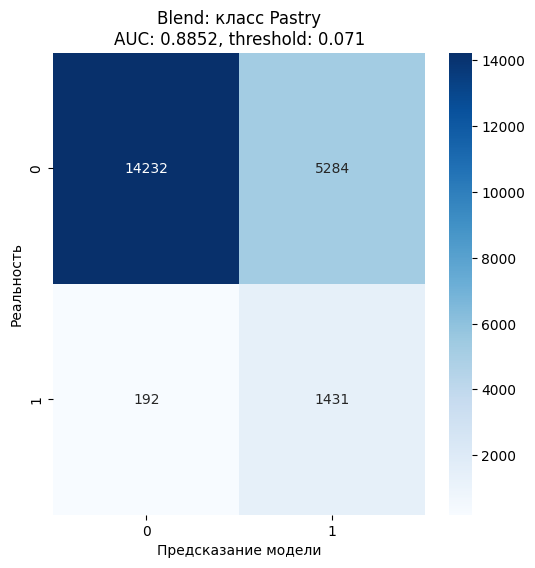

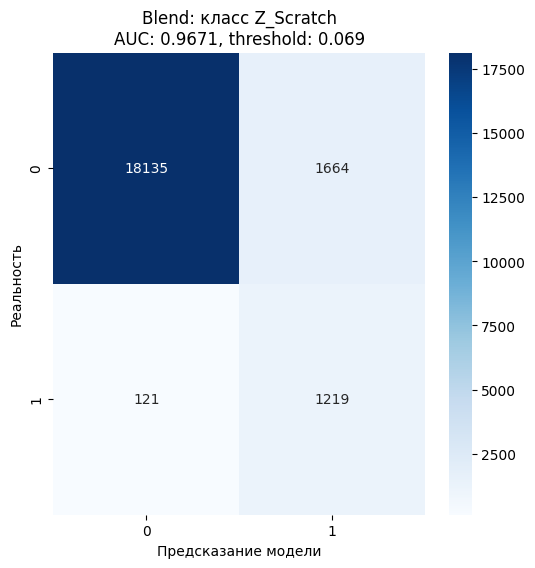

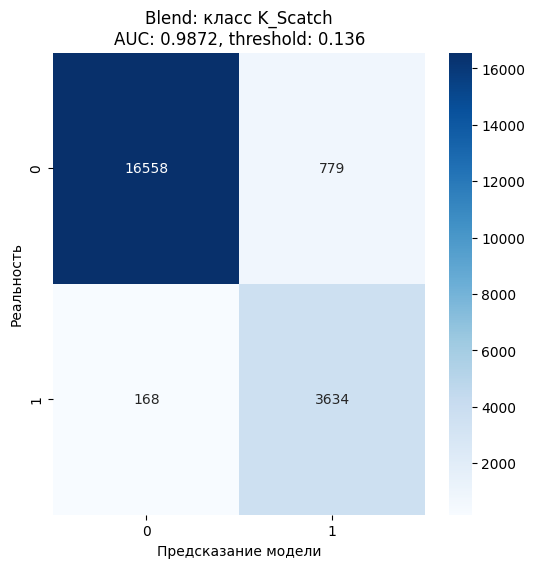

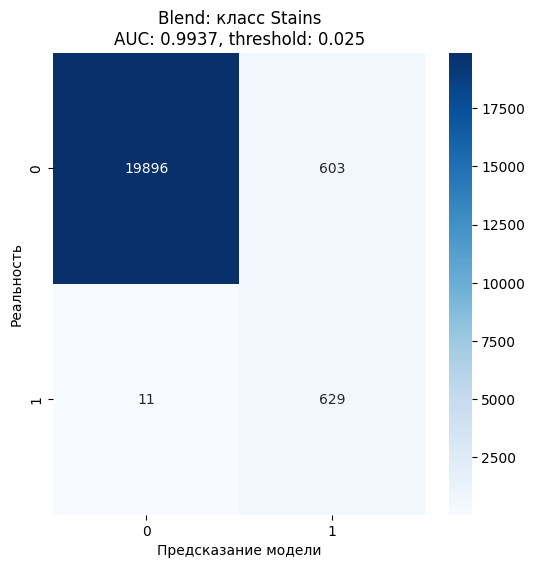

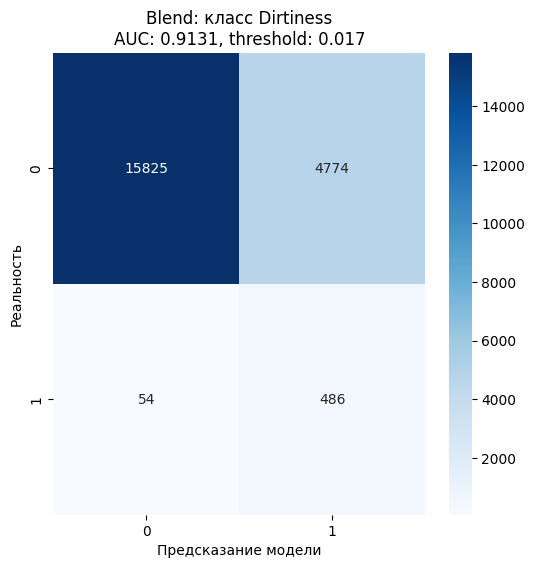

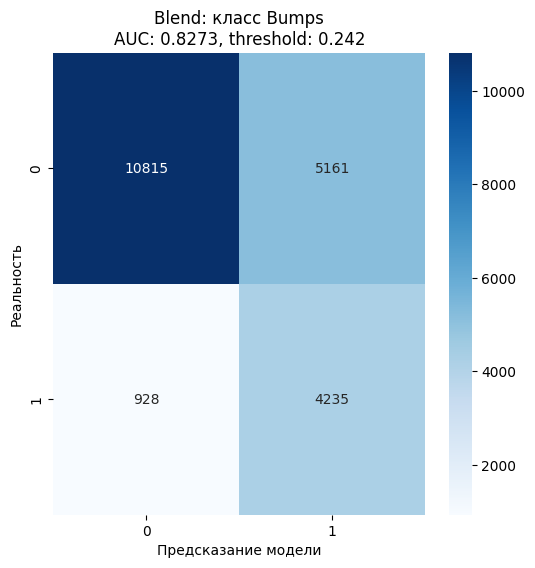

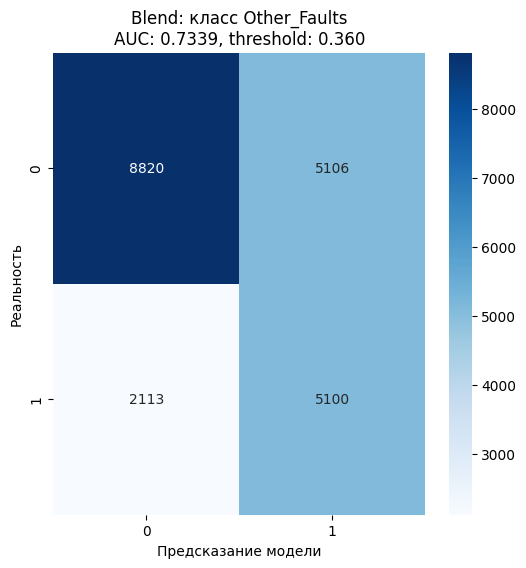

In [32]:
from sklearn.metrics import roc_curve, confusion_matrix, roc_auc_score

def find_optimal_threshold(y_true, y_prob):
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    return optimal_threshold

roc_auc_scores = []

for i, c in enumerate(TARGET_FEATURES):
    y_true = targets_bin.iloc[:, i]
    y_prob = blend[:, i]
    
    # Оптимальный порог
    opt_th = find_optimal_threshold(y_true, y_prob)
    
    # AUC score
    auc_score = roc_auc_score(y_true, y_prob)
    roc_auc_scores.append(auc_score)
    
    # Предсказания по оптимальному порогу
    y_pred = (y_prob > opt_th).astype(int)
    
    # Визуализация confusion matrix
    plt.figure(figsize=(6, 6))
    plt.title(f"Blend: класс {c}\nAUC: {auc_score:.4f}, threshold: {opt_th:.3f}")
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='g', cmap='Blues')
    plt.xlabel("Предсказание модели")
    plt.ylabel("Реальность")
    plt.show()

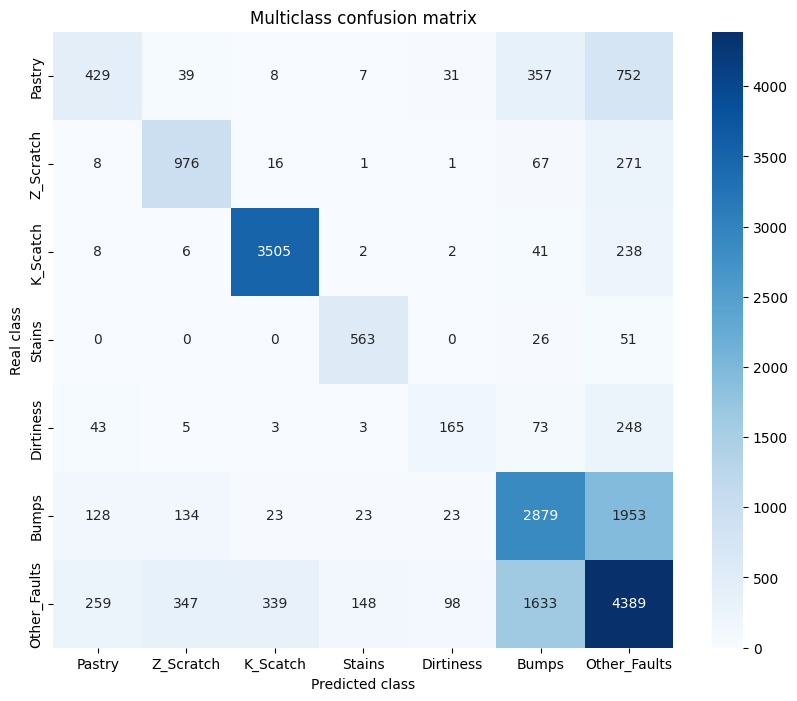

In [33]:
# 1. Считаем оптимальные трешхолды для каждого класса
optimal_thresholds = []
for i in range(len(TARGET_FEATURES)):
    y_true_bin = targets_bin.iloc[:, i]
    y_prob = blend[:, i]
    opt_th = find_optimal_threshold(y_true_bin, y_prob)
    optimal_thresholds.append(opt_th)

# 2. Для каждого сэмпла определяем класс по трешхолдам
preds_by_threshold = []
for row in blend:
    passed = [i for i, prob in enumerate(row) if prob > optimal_thresholds[i]]
    if passed:
        # Если несколько классов превысили трешхолд — берём с максимальной вероятностью
        best = max(passed, key=lambda i: row[i])
        preds_by_threshold.append(best + 1)  # +1 если Target с 1, иначе уберите
    else:
        # Если ни один не превысил — fallback: класс с максимальной вероятностью
        preds_by_threshold.append(np.argmax(row) + 1)

# 3. Строим confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y, preds_by_threshold, labels=range(1, len(TARGET_FEATURES)+1))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=TARGET_FEATURES, yticklabels=TARGET_FEATURES)
plt.xlabel("Predicted class")
plt.ylabel("Real class")
plt.title("Multiclass confusion matrix")
plt.show()

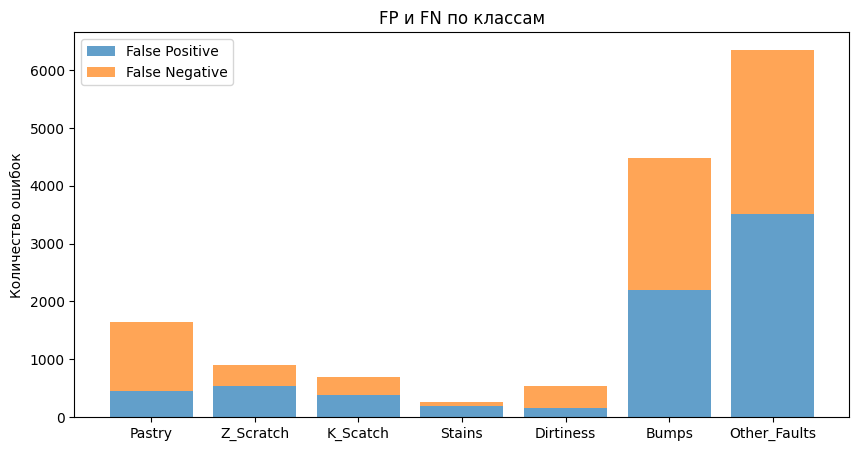

In [34]:
fp = cm.sum(axis=0) - np.diag(cm)  # False Positive по каждому классу
fn = cm.sum(axis=1) - np.diag(cm)  # False Negative по каждому классу

plt.figure(figsize=(10, 5))
plt.bar(TARGET_FEATURES, fp, label='False Positive', alpha=0.7)
plt.bar(TARGET_FEATURES, fn, label='False Negative', alpha=0.7, bottom=fp)
plt.ylabel('Количество ошибок')
plt.title('FP и FN по классам')
plt.legend()
plt.show()